<a href="https://colab.research.google.com/github/christina3099/Cats-Vs-Dogs-CNN/blob/main/Cats_Vs_Dogs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/microsoft-catsvsdogs-dataset


In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 622.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
import os
from sklearn.model_selection import train_test_split

In [4]:
dataset_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')

In [5]:
data = []
for label in ["Cat","Dog"]:
    for file in os.listdir(os.path.join(dataset_dir,label)):
        data.append([os.path.join(dataset_dir,label,file),label])

In [6]:
df = pd.DataFrame(data,columns=['image','label'])

In [34]:
df.head()

,image,label
0,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
1,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
2,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
3,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
4,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat


In [7]:
df.shape

(25002, 2)

In [9]:
df["label"].value_counts() #No class imbalance seen

,count
label,
Cat,12501
Dog,12501


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   25002 non-null  object
 1   label   25002 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [36]:
df.describe()

,image,label
count,25002,25002
unique,25002,2
top,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
freq,1,12501


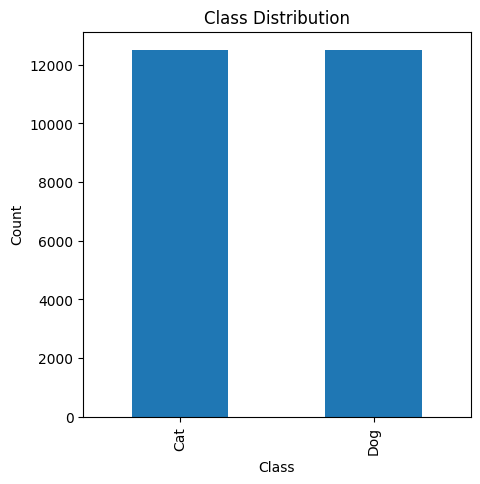

In [12]:
plt.figure(figsize=(5,5))
df["label"].value_counts().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2,stratify=df['label'],random_state=42)

In [33]:
from PIL import Image
from sklearn.preprocessing import LabelEncoder

def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except Exception:
        return False

# Apply the filter to the DataFrame
train_df_cleaned = train_df[train_df['image'].apply(is_valid_image)].copy()
val_df_cleaned = val_df[val_df['image'].apply(is_valid_image)].copy()




/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [37]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator =train_datagen.flow_from_dataframe(
    train_df_cleaned,
    target_size = (256,256),
    x_col = "image",
    y_col = "label",
    label_mode = "binary",
    batch_size=32,
    class_mode='binary',
    shuffle=True

)
validation_generator = val_datagen.flow_from_dataframe(
    val_df_cleaned,
    target_size = (256,256),
    x_col ="image",
    y_col ="label",
    label_mode ="binary",
    batch_size=32,
    class_mode='binary',
    shuffle=True

)

Found 19997 validated image filenames belonging to 2 classes.
Found 5001 validated image filenames belonging to 2 classes.


In [38]:
#Model building

model = Sequential([
    Conv2D(32, (3, 3), padding='valid',activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Conv2D(64, (3, 3), padding='valid',activation='relu'),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Conv2D(128, (3, 3), padding='valid',activation='relu'),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,297 (56.64 MB)

 Trainable params: 14,847,297 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
# Convert generators to tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 256, 256, 3], [None,])
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 256, 256, 3], [None,])
)


history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_dataset,
    validation_steps=len(validation_generator)
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'SymbolicTensor'

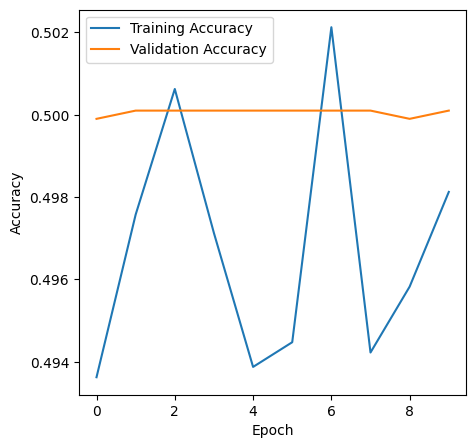

In [21]:
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
model1 = Sequential([
    Conv2D(32, (3, 3), padding='valid',activation='relu', input_shape=(228, 228, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Conv2D(64, (3, 3), padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Conv2D(128, (3, 3), padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 226, 226, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 226, 226, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 53, 53, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 53, 53, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,177 (42.64 MB)

 Trainable params: 11,177,729 (42.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
model1.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
history = model1.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5008 - loss: 11.4137

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 345s 541ms/step - accuracy: 0.5008 - loss: 11.4010 - val_accuracy: 0.5001 - val_loss: 0.6933
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 373s 534ms/step - accuracy: 0.5069 - loss: 0.7008 - val_accuracy: 0.5001 - val_loss: 0.6935
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 332s 532ms/step - accuracy: 0.5040 - loss: 0.6954 - val_accuracy: 0.5001 - val_loss: 0.6933
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 333s 533ms/step - accuracy: 0.5038 - loss: 0.6945 - val_accuracy: 0.4999 - val_loss: 0.6932
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 333s 533ms/step - accuracy: 0.5058 - loss: 0.6942 - val_accuracy: 0.4999 - val_loss: 0.6935
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 382s 533ms/step - accuracy: 0.5049 - loss: 0.6954 - val_accuracy: 0.5001 - val_loss: 0.6936
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 380s 530ms/step - accuracy: 0.5076 - loss: 0.6959 - val_accuracy: 0.5001 - val_loss: 0.6934
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 333s 532ms/step - accuracy: 0.5043 - loss: 0.6

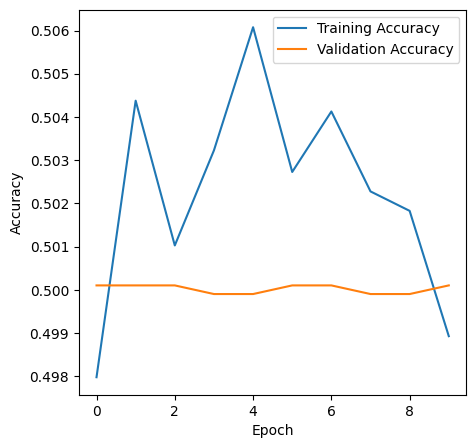

In [32]:
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
import keras.regularizers as regularizers
model2 = Sequential([
    Conv2D(32, (3, 3), padding='valid',activation='relu', input_shape=(228, 228, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Conv2D(64, (3, 3), padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Conv2D(128, (3, 3), padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Flatten(),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [37]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 226, 226, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 226, 226, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 53, 53, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 53, 53, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,177 (42.64 MB)

 Trainable params: 11,177,729 (42.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [38]:
model2.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
history = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]  # Add early stopping callback
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5116 - loss: 18.4668

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 341s 536ms/step - accuracy: 0.5116 - loss: 18.4490 - val_accuracy: 0.4959 - val_loss: 1.0255
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 375s 531ms/step - accuracy: 0.5124 - loss: 0.9423 - val_accuracy: 0.5477 - val_loss: 0.8162
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 381s 530ms/step - accuracy: 0.5337 - loss: 0.8707 - val_accuracy: 0.5001 - val_loss: 0.7543
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 387s 538ms/step - accuracy: 0.5105 - loss: 0.9034 - val_accuracy: 0.4999 - val_loss: 0.8401
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 334s 534ms/step - accuracy: 0.5080 - loss: 0.8637 - val_accuracy: 0.5001 - val_loss: 0.7124
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 332s 531ms/step - accuracy: 0.5162 - loss: 0.8244 - val_accuracy: 0.4999 - val_loss: 0.7134
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 336s 538ms/step - accuracy: 0.5031 - loss: 0.7271 - val_accuracy: 0.5001 - val_loss: 0.6998
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 346s 554ms/step - accuracy: 0.5013 - loss: 0.6

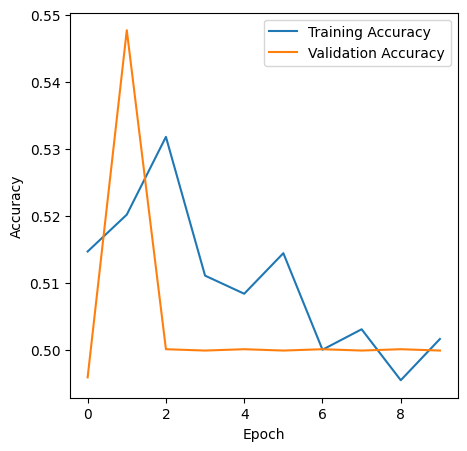

In [40]:
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
import keras.regularizers as regularizers
model4 = Sequential([
    Conv2D(32, (3, 3), padding='valid',activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Conv2D(64, (3, 3), padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Conv2D(128, (3, 3), padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=(2,2), padding ='valid'),
    Flatten(),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model4.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
model4.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
history = model4.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: No gradients provided for any variable.